# XGBoost Demo

Notebook: `xgboost_interpretibility_demo.ipynb`

Author: Christian Jo and Mia Jerphagnon

Date: 9/23/24

Description: <br>
This notebook contains a demo on using XGBoost to predict the probability of an individual making over $50K a year in annual income. <br>
The main focus of this demo is to showcase the interpretibility capabilities of the model results using SHAP values.
    
Dependencies: 
- `numpy`: For numerical computations
- `matplotlib`: A plotting library used to create visualizations
- `sklearn`: Provides a range of tools for ML and statistical modeling, including model training, data preprocessing, and model evaluation
- `xgboost`: Provides the XGBoost implementation of gradient boosting
- `shap`: Provides tools for interpreting ML models by computing SHAP values

In [1]:
# Import necessary libraries
import matplotlib.pylab as pl
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split

import shap

# To print the JS visualization code to the notebook
shap.initjs()

## Load the Dataset

In this code, we are working with a dataset that contains information about people, such as their age, education, and job. The goal is to predict whether a person earns more than $50,000 a year based on these details.

First, we load the data and separate it into two parts: one for training the model (teaching it how to make predictions) and one for testing it (checking how well the model can predict on new data). We use a special data format that helps make this process faster and more efficient for the computer. 

Once the data is ready, we can build and test our model to see how accurate it is at predicting whether someone earns more than $50,000.

In [2]:
# Loading the dataset from the shap library
X, y = shap.datasets.adult() # If display=False, X contains numerical representations of each category values
X_display, y_display = shap.datasets.adult(display=True) # If display=True, X contains the original category value strings

# Create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# DMatrix is a data structure the XGBoost developers created for memory efficiency and training speed
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [3]:
# Number of rows and columns in X
X.shape

(32561, 12)

In [4]:
# A preview of the first 5 rows of X
X.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [5]:
# A preview of the first 5 rows of X_display
X_display.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


## Train the Model

Setting the parameters for the model:
- `eta`: The learning rate of the model.
- `gamma`: Minimum loss reduction required to make a further partition on a leaf node of the tree. Used for pruning.
- `max_depth`: The maximum depth of a tree.
- `lambda`: L2 regularization term on weights. Increasing this value will make the model more conservative.
- `objective`: Specifies the learning task athe the corresponding learning objective.
- `subsample`: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees.
- `base_score`: The initial prediction score of all instances, global bias.
- `eval_metric`: Evaluation metrics for validation data.

In [6]:
params = {
    "eta": 0.01,
    "gamma": 0,
    "max_depth": 6,
    "lambda": 1,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}

model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

[0]	test-logloss:0.54666
[100]	test-logloss:0.36390
[200]	test-logloss:0.31754
[300]	test-logloss:0.30058
[400]	test-logloss:0.29155
[500]	test-logloss:0.28652
[600]	test-logloss:0.28343
[700]	test-logloss:0.28173
[800]	test-logloss:0.28058
[900]	test-logloss:0.27976
[1000]	test-logloss:0.27924
[1100]	test-logloss:0.27893
[1200]	test-logloss:0.27878
[1208]	test-logloss:0.27876


## Feature Importance Calculations with Plot Importance

Feature importance measures how important each feature is to a model's ability to predict a target variable. XGBoost comes with its own built in function for calculating feature importance called `plot_importance`. 
<br>
The `plot_importance` function has three options for how it calculates importance in the `importance_type` parameter: <br>
>    - _weight_ is the number of times a feature appears in a tree <br>
>    - _gain_ is the average gain of splits which use the feature <br>
>    - _cover_ is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split. <br>

Each `importance_type` results in a different ordering of features when using `plot_importance`. This creates uncertainty. Additionally, `plot_importance` has been found to be inconsistent and cannot be fully trusted to accurately assign more importance to the most influential features.

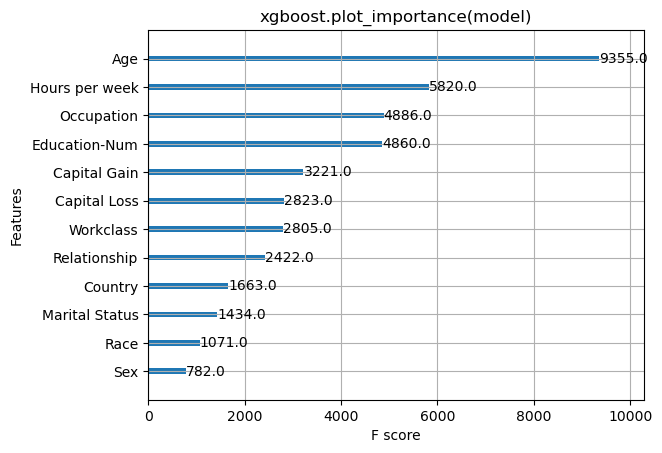

In [7]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

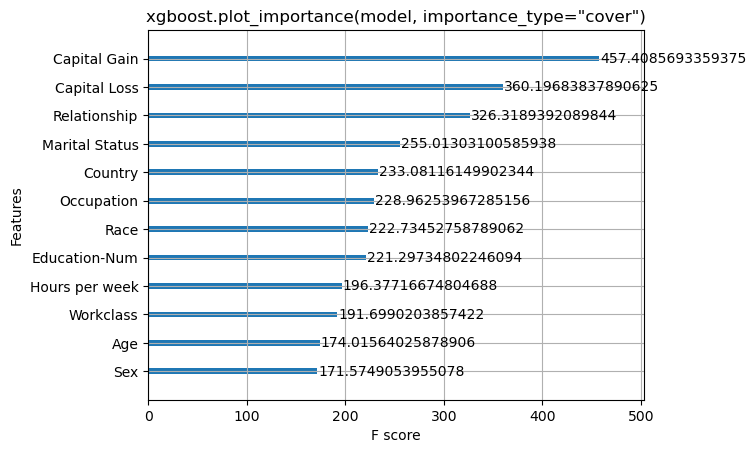

In [8]:
xgboost.plot_importance(model, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

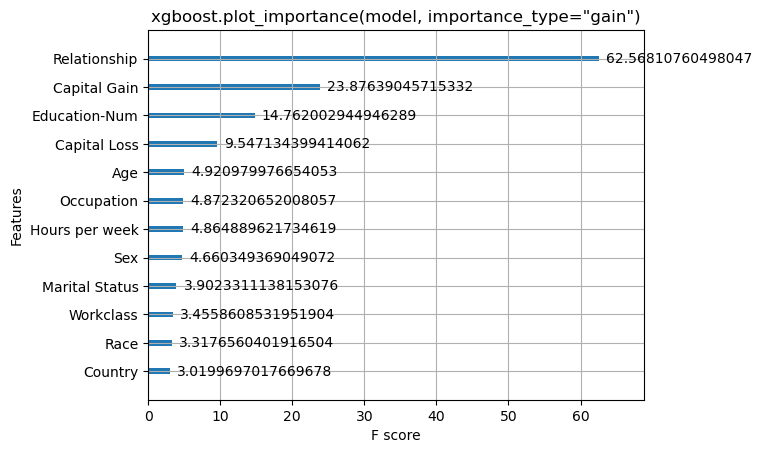

In [9]:
xgboost.plot_importance(model, importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

## Introduction to SHAP Values

**SHapley Additive exPlanations** (SHAP) is a game theory-based approach to explain individual predictions. <br>
It combines local and global interpretability. <br>
Values assigned to features reflect contribution to the prediction. <br>
  
Pros:
- Consistency of SHAP value increasing when increased contribution to model
- Visual interpretability

Cons: 
- Computational expense
- Does not capture true causality

### SHAP Waterfall Plot
- The units on the x-axis are log-odd units, so negative values imply probabilities of less than 0.5 that the person makes over $50k annually.
- The bottom of the waterfall plot starts as the expected value of the model output.

In [10]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

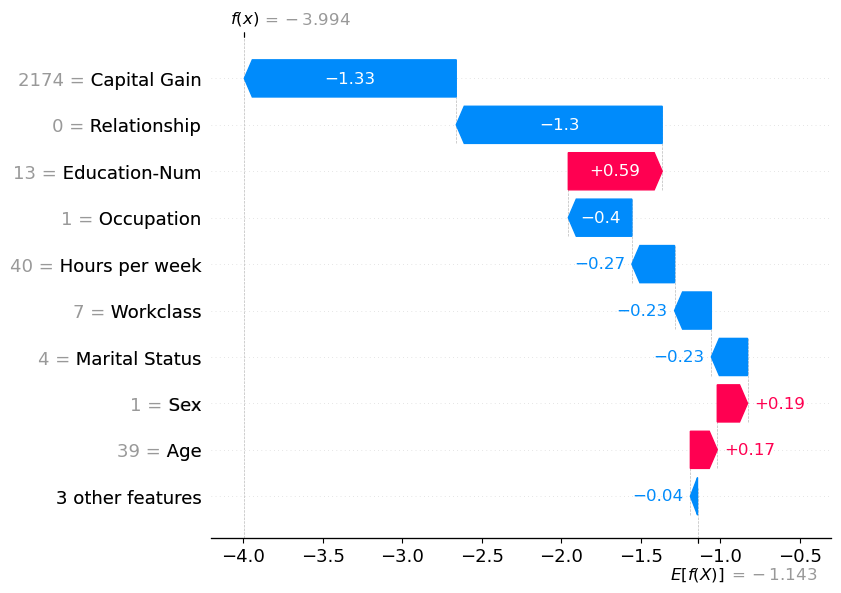

In [11]:
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

### Mean Importance Bar Chart
- The global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.
- Whether it's negative or positive → overall effect on prediction

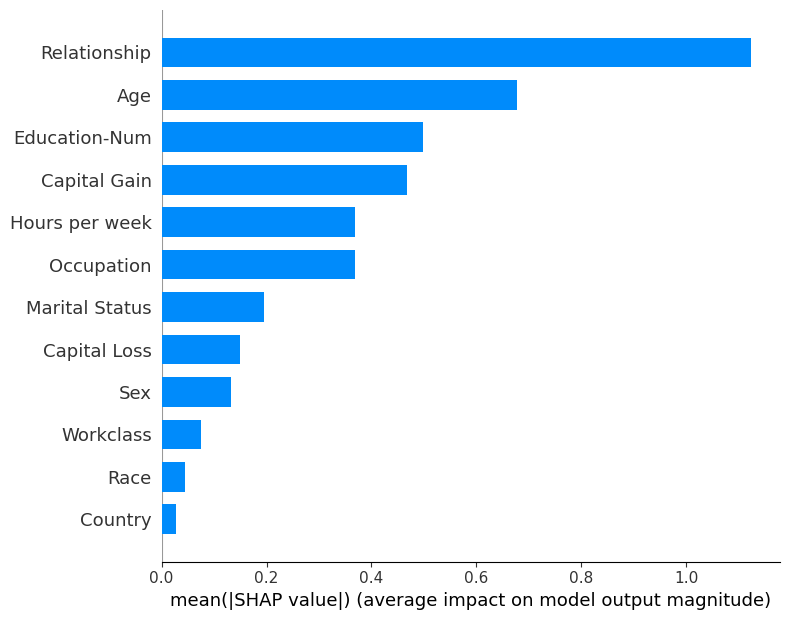

In [14]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

### SHAP Force Plot

In [12]:
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation with a force plot
shap.force_plot(explainer.expected_value, shap_values[0, :], X_display.iloc[0, :])

In [13]:
shap.force_plot(explainer.expected_value, shap_values[:1000, :], X_display.iloc[:1000, :])

### SHAP Summary Plot
**Distribution and Variability**

The SHAP summary plot offers a compact representation of the distribution and variability of SHAP values for each feature.

The taller, or thicker, areas indicate higher density and more frequent values.

The plot provides insights into the range, variability, skewness, symmetry, and multimodality of the SHAP value distribution. 

For example, let's take a look at the age variable. Being younger (as shown in blue) has a large range of negative impact on model output. For older folks (those in purple and red), the range is smaller, but positive. So we can conclude that as you get older, age becomes less important in magnitude, but the impact switches directions from a negative to a positive impact.

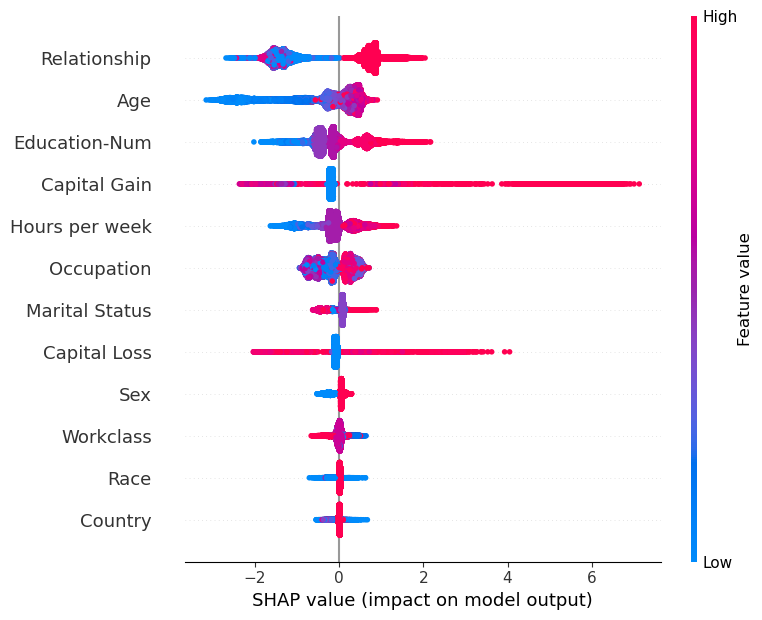

In [15]:
shap.summary_plot(shap_values, X)

### SHAP Dependence Plot
Another plot, the SHAP dependence plot, shows the interaction effects between features. 

Let's take a look at the first example between age and education. 

As with the previous plot, we can infer that as age increases, age's impact on the model changes from negative to positive. We can also see the large negative range of people in their 20s, which was the range of blue in the summary plot. 

Interestingly, there is a dispersion of 20-year-olds specifically (vertical cluster above year 20). Even though this means that there are many 20-year-olds in the data set, how much their age impacts their prediction differs. 
→ This means that other features are impacting the importance of age.

That's why we ran a dependence plot between age and education!

At 20 years old, having a higher education has a stronger negative impact. You can see this in the cluster where the red is lower than purple and blue. That makes sense when thinking about university students who are not working vs non-students who join the work force earlier.

After, as age increases, the red values are higher on the graph than blue. Having a higher-education becomes more beneficial later on in life.

After retirement, it's less likely people make over $50,000. Also, education is not as important, as seen by the fall in red compared to the other colors. 

Education key:
- 1: Preschool 
- 2: 1st-4th
- 3: 5th-6th
- 4: 7th-8th
- 5: 9th
- 6: 10th
- 7: 11th
- 8: 12th
- 9: HS-Grad
- 10: Some College
- 11: Assoc-voc
- 12: Assoc-acdm
- 13: Bachelor
- 14: Grad School
- 15: Prof-school
- 16: Doctorate


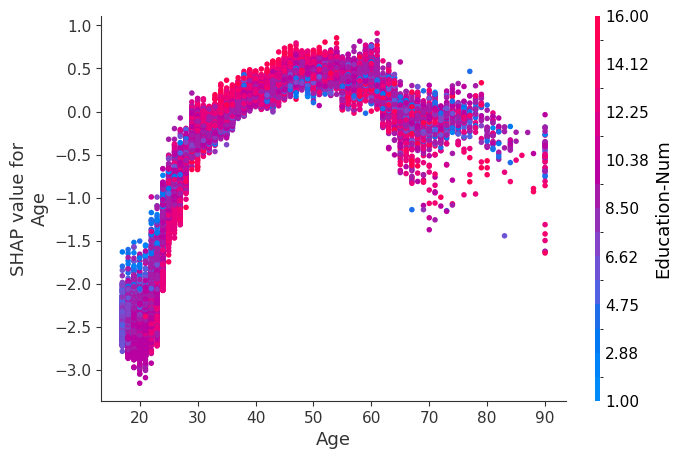

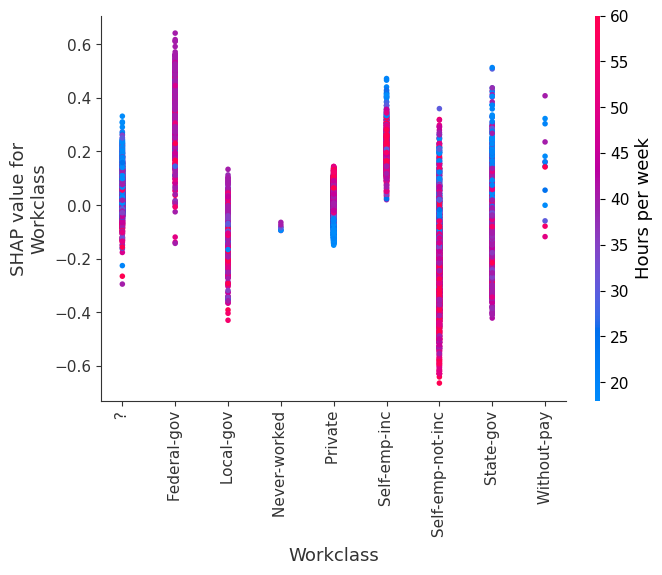

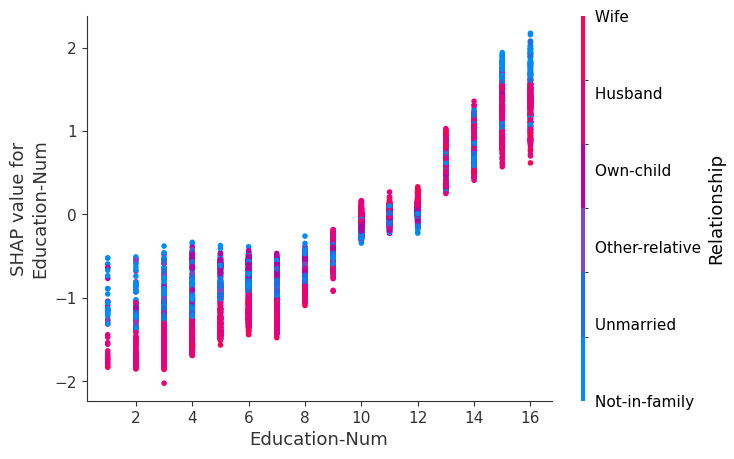

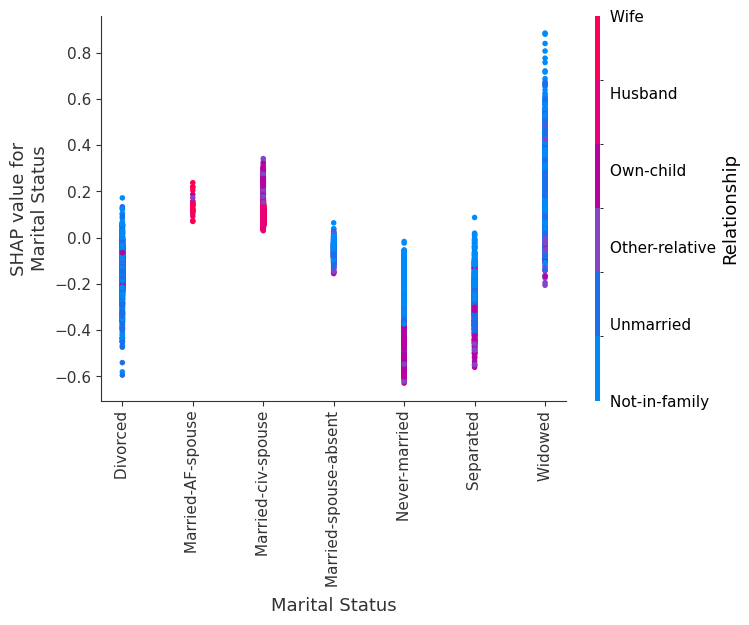

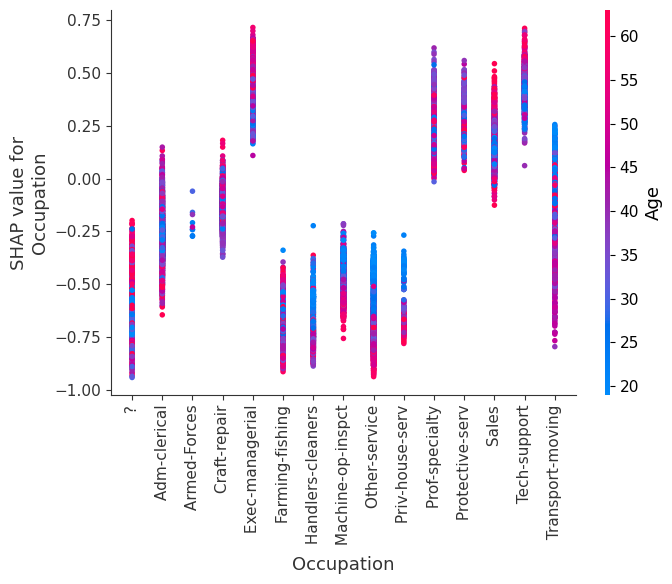

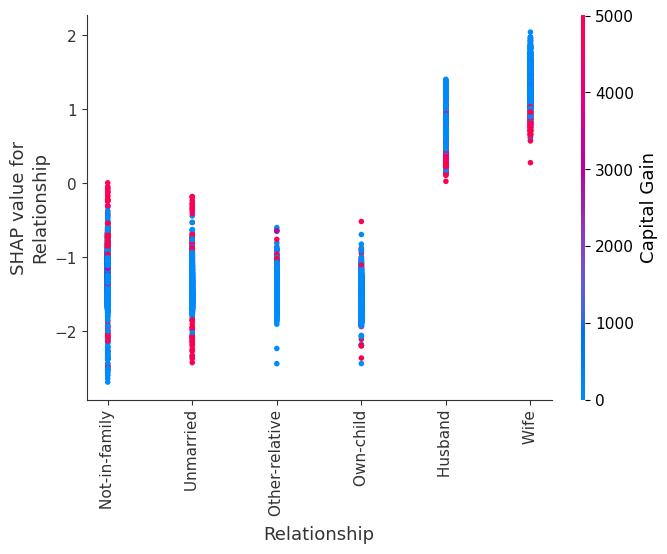

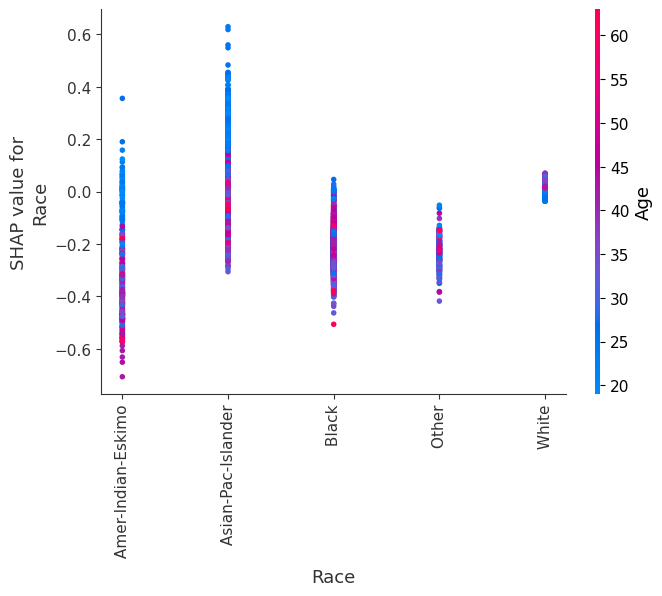

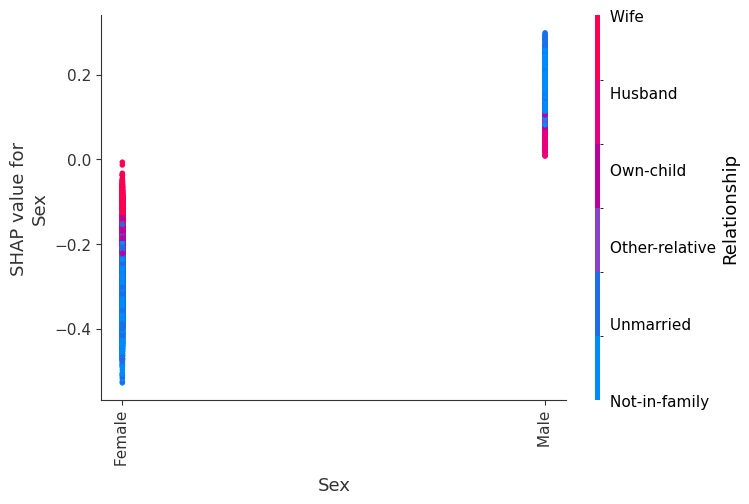

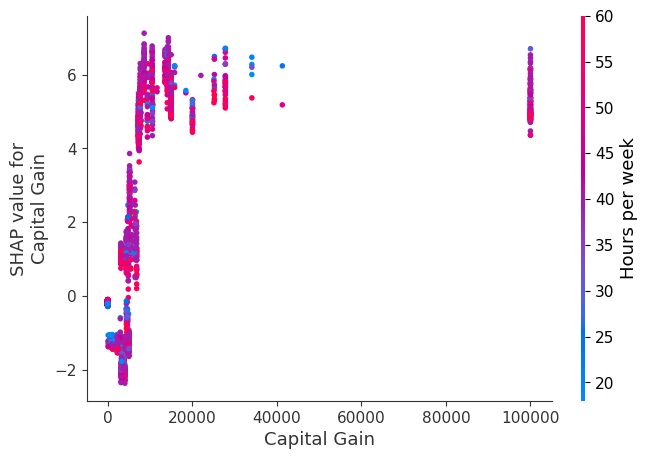

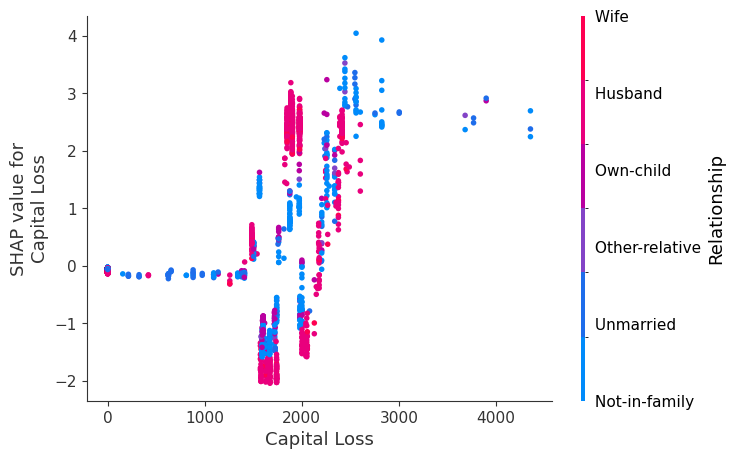

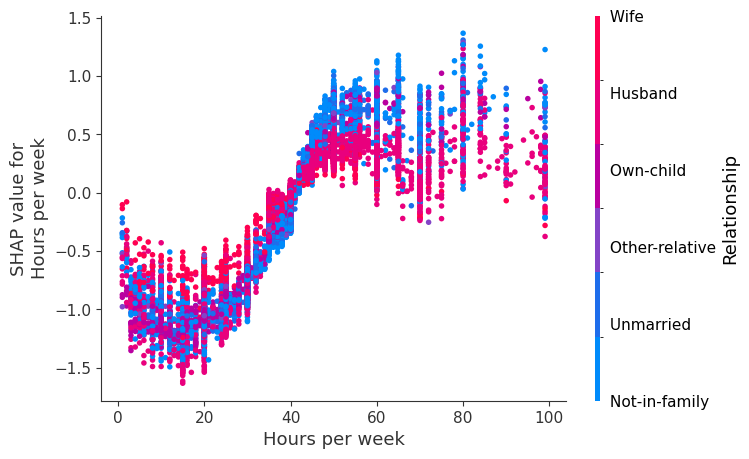

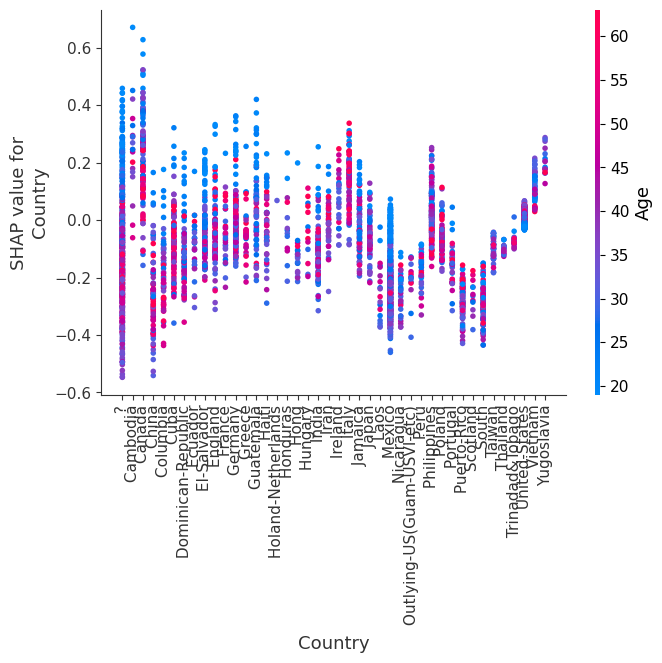

In [16]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)

1: Preschool
2: 1st-4th
3: 5th-6th
4: 7th-8th
5: 9th
6: 10th
7: 11th
8: 12th
9: HS-Grad
10: Some College
11: Assoc-voc
12: Assoc-acdm
13: Bachelor
14: Grad School
15: Prof-school
16: Doctorate

## Sources

Abualdenien, J. (n.d.). Ensemble-learning approach for the classification of Levels Of Geometry (LOG) of building elements. Retrieved from https://www.researchgate.net/figure/eXtreme-Gradient-Boosting-XGBoost-Schematic-Representation-it-builds-decision-trees_fig2_357741497

Brownlee, J. (2016, August 30). Feature Importance and Feature Selection With XGBoost in Python. Retrieved from Machine Learning Mastery website: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

Lundberg, S. (2018). Be careful when interpreting predictive models in search of causal insights — SHAP latest documentation. Retrieved from Readthedocs.io website: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%20insights.html

Lundberg, S. (2020, October 6). Interpretable Machine Learning with XGBoost. Retrieved from Medium website: https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

Płoński, P. (2020, August 17). Xgboost Feature Importance Computed in 3 Ways with Python. Retrieved from MLJAR Automated Machine Learning website: https://mljar.com/blog/feature-importance-xgboost/
